# AdaBoost (1)

Adaptive Boost

`초기 모형을 약한 모형으로 설정`하며 `매 스탭마다 가중치를 이용`하여 `이전 모형의 약점을 보완하는 방식`으로 `새로운 모형을 순차적으로 학습`하고 `최종적으로 이들을 선형 결합하여 얻어진 모형을 생성`하는 알고리즘.

## #01. 패키지

In [29]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sb
# 회귀를 위한 더미변수 생성
from pandas import read_excel, DataFrame, melt

from sklearn.ensemble import AdaBoostClassifier #분류
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier

# 데이터 불균형 해소를 위한 smpling 패키지
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearnex import patch_sklearn
#GPU 사용 가능시
from daal4py.oneapi import sycl_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 데이터

In [17]:
origin = read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")
# print(origin.info())
origin.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## #03. 데이터 전처리

### 독립/종속변수 분리

In [18]:
origin.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [19]:
x = origin.drop('target', axis=1)
y = origin['target']
x.shape, y.shape

((569, 30), (569,))

### 훈련/검증 데이터 분리

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

### 데이터 불균형 처리

### 데이터 불균형 해소

#### Over Sampling - SMOTE

소수 집단의 데이터를 바탕으로 새로운 데이터를 생성.

단순히 소수 집단의 데이터를 복원 추출하는 것이 아니라 소수 집단 데이터를 분석해 어떤 특징이 있는지 살피고 그와 유사한 패턴을 가지는 가짜 데이터를 생성.

##### `sampling_strategy 파라미터`

sampling_strategy : 2진 분류일 경우 실수로 설정 가능

| 값 | 설명 |
| -- | -- |
| `minority` | `소수 클래스만` 다시 샘플링 |
| `not majority` | `다수 아님` : 다수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `not minority` | `소수 아님` : 소수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `all` | `모든 클래스`를 다시 샘플링 |
| `auto` | 자동 처리 |

혹은 실수 타입으로 설정할 경우 샘플 수의 비율을 의미

##### `k_neighbors 파라미터 (int)`

합성 샘플을 생성하는데 사용할 샘플의 가장 가까운 이웃 수 (기본값=5)

In [21]:
smote_sampler = SMOTE(sampling_strategy='minority', random_state=777)
x_sm, y_sm = smote_sampler.fit_resample(x_train, y_train)
print(x_sm.shape, y_sm.shape)

y_sm.value_counts().sort_index()

(508, 30) (508,)


target
0    254
1    254
Name: count, dtype: int64

## #04. 훈련 모델 적합

### 단일 모형

부스팅에 사용할 학습 알고리즘 생성

In [22]:
dt = DecisionTreeClassifier(
    max_depth=2, min_samples_leaf=10, random_state=123
)
dt

DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, random_state=123)

#### AdaBoost 생성

n_estimators : 반복 횟수

In [24]:
# 모델 생성
ada = AdaBoostClassifier(
    base_estimator=dt,  # 훈련에 사용할 학습 모델
    n_estimators=100,   # 학습 모델의 개수(반복 횟수)
    random_state=123
)
# 모델 학습
ada.fit(x_sm, y_sm)

print("훈련 정확도 :", ada.score(x_sm, y_sm))

# 예측 값
y_pred = ada.predict(x_test)
print("테스트 정확도 :", accuracy_score(y_test, y_pred))

훈련 정확도 : 1.0
테스트 정확도 : 0.9707602339181286


### 분류 보고서

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        68
           1       0.97      0.98      0.98       103

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



#### ROC 곡선

##### 각 클래스에 속할 확률에서 `1`에 속할 확률만 구함

In [27]:
score1 = ada.predict_proba(x_test)[:,1]
score1[:5]

array([0.98464707, 0.97697064, 0.11817338, 0.95471553, 0.07436144])

##### ROC 점수 구하기

실제 Label과 Positive Label에 대한 예측 확률을 전달하여 roc 곡선 표현에 필요한 값들을 리턴받는다.

- 첫 번째 리턴 값 : False Positive Rate(민감도)
- 두 번째 리턴 값 : True Positive Rate(재현율)
- 세 번째 리턴 값 : 절단값(ROC 커브 구현에 사용되지 않음)

In [30]:
fpr1, tpr1, cut1 = roc_curve(y_test, score1)

##### ROC 곡선 시각화

ROC 곡선이 가운데 직선에 가까울 수록 분류 성능이 떨어짐을 의미.

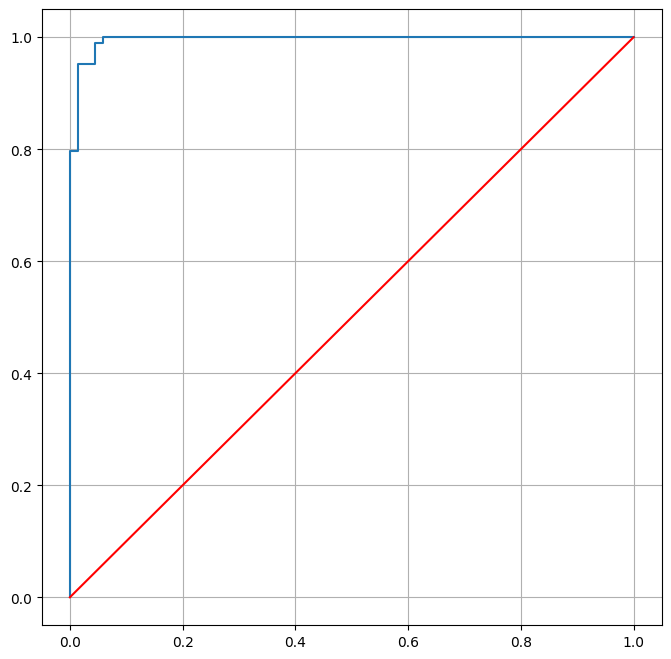

In [31]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(fpr1, tpr1)
ax.plot([0, 1], [0, 1], color='red')
plt.grid()
plt.show()
plt.close()

###### ROC 곡선 예쁘게 시각화

<Figure size 800x800 with 0 Axes>

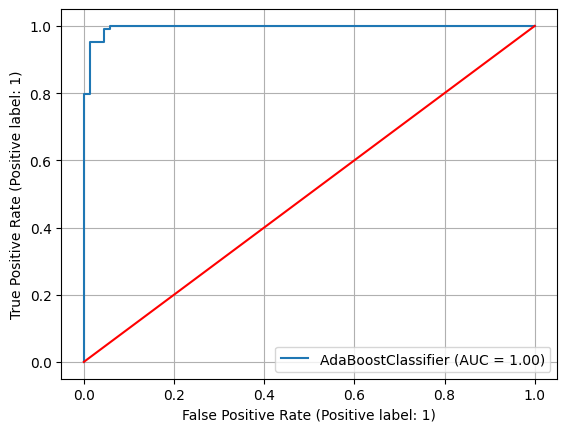

In [33]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(ada, x_test, y_test)
plt.plot([0, 1], [0, 1], color='red')
plt.grid()
plt.show()
plt.close()

### AUC 값 직접 계산

#### 실제 Label과 Positive의 예측 확률로 계산

In [34]:
print('roc_auc_score 함수 결과 :', roc_auc_score(y_test, score1))

roc_auc_score 함수 결과 : 0.9954311821816105


#### False Positive Rate와 True Positive Rate로 계산

In [35]:
print('auc 함수 결과 :', auc(fpr1, tpr1))

auc 함수 결과 : 0.9954311821816105
